In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score,silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
customers = pd.read_csv('Customers.csv')
products = pd.read_csv('Products.csv')
transactions = pd.read_csv('Transactions.csv')

In [3]:
transactions = transactions.merge(products, on='ProductID', how='left')
data = transactions.merge(customers, on='CustomerID', how='left')

In [4]:
data = data.drop('Price_x', axis = 1)
data = data.rename(columns={'Price_y': 'Price'})

In [5]:
data.head()

,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,ProductName,Category,Price,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,ComfortLiving Bluetooth Speaker,Electronics,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,ComfortLiving Bluetooth Speaker,Electronics,300.68,Timothy Perez,Europe,2022-03-15


In [6]:
# Aggregating data for clustering
customer_summary = data.groupby('CustomerID').agg({
    'TotalValue': 'sum',
    'TransactionID': 'count',
    'Quantity': 'sum',
    'Price': 'mean',  # Average price of products bought
}).rename(columns={
    'TransactionID': 'TransactionCount',
    'Price': 'AvgPrice'
})


In [7]:
customer_summary = customer_summary.merge(customers[['CustomerID', 'Region']], on='CustomerID', how='left')

In [8]:
# One-hot encode the 'Region' column
customer_summary = pd.get_dummies(customer_summary, columns=['Region'], drop_first=True)

In [9]:
# Scaling data for clustering
scaler = StandardScaler()
scaled_data = scaler.fit_transform(customer_summary.drop('CustomerID', axis=1))

In [10]:
# Clustering using KMeans
inertia = []
db_scores = []
k_range = range(2, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    clusters = kmeans.fit_predict(scaled_data)
    db_index = davies_bouldin_score(scaled_data, clusters)
    inertia.append(kmeans.inertia_)
    db_scores.append(db_index)


In [11]:
optimal_k = k_range[np.argmin(db_scores)]
print(f"Optimal number of clusters: {optimal_k}")

Optimal number of clusters: 10


In [12]:
# Final KMeans model
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
customer_summary['Cluster'] = kmeans.fit_predict(scaled_data)

In [13]:
silhouette_avg = silhouette_score(scaled_data, customer_summary['Cluster'])

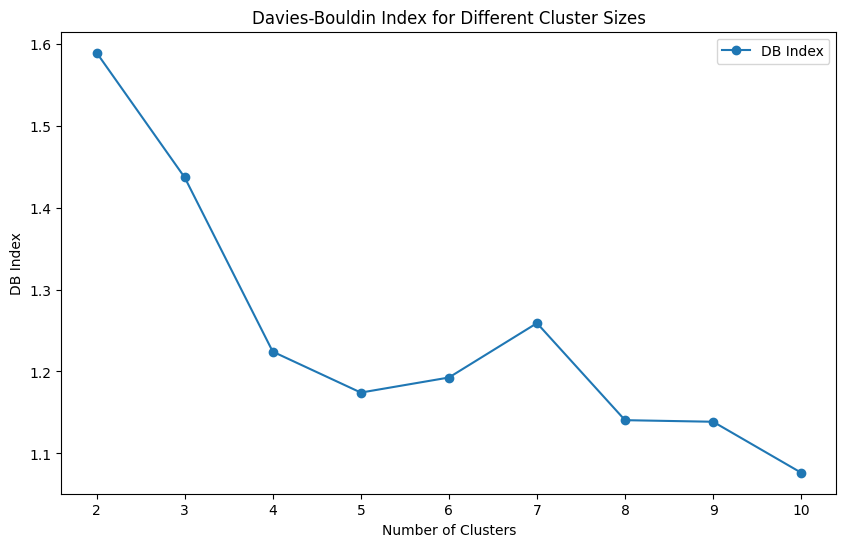

In [14]:
# Visualization of DB Index
plt.figure(figsize=(10, 6))
plt.plot(k_range, db_scores, marker='o', label='DB Index')
plt.title('Davies-Bouldin Index for Different Cluster Sizes')
plt.xlabel('Number of Clusters')
plt.ylabel('DB Index')
plt.legend()
plt.show()

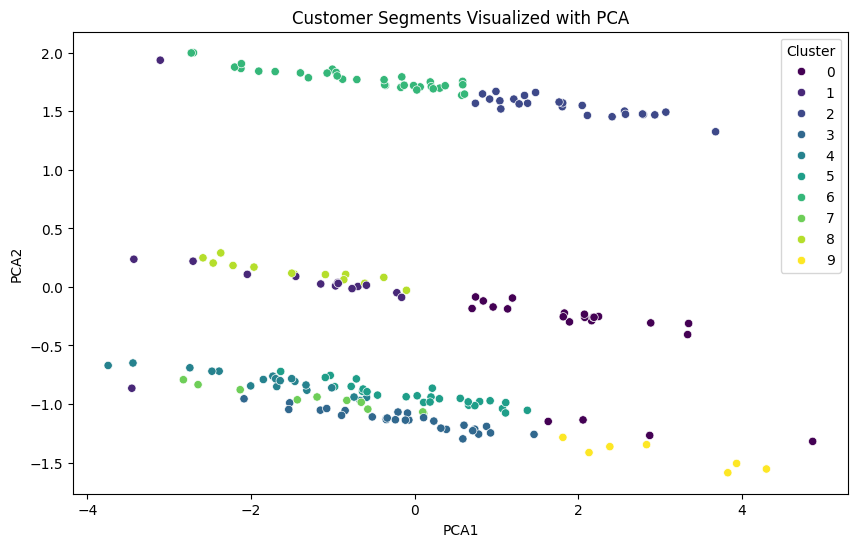

In [15]:
# Visualizing clusters with PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principal_components = pca.fit_transform(scaled_data)
customer_summary['PCA1'] = principal_components[:, 0]
customer_summary['PCA2'] = principal_components[:, 1]

plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1', y='PCA2', hue='Cluster', data=customer_summary,
    palette='viridis', legend='full'
)
plt.title('Customer Segments Visualized with PCA')
plt.show()

In [16]:
# Report clustering metrics
print(f"Davies-Bouldin Index for optimal clusters ({optimal_k}): {min(db_scores):.2f}")
print(f"Silhouette Score: {silhouette_avg:.4f}")

Davies-Bouldin Index for optimal clusters (10): 1.08
Silhouette Score: 0.3174
